In [6]:
import os
import re
from dotenv import load_dotenv

# Load .env file
load_dotenv()

# Access environment variables
DEFAULT_STRIKE = os.getenv('DEFAULT_STRIKE', 'ATM')
DEFAULT_MATURITY = os.getenv('DEFAULT_MATURITY', '1Y')
RISK_FREE_RATE_API = os.getenv('RISK_FREE_RATE_API')
DIVIDEND_YIELD = float(os.getenv('DIVIDEND_YIELD', 0.02))
import pandas as pd

# Load options data and Greeks data from Parquet files
option_data = pd.read_parquet('./data/options_data.parquet')
greeks_data = pd.read_parquet('./data/greeks_data.parquet')

In [7]:
class Node:
    pass

class WeightedAssetNode(Node):
    def __init__(self, asset, weight):
        self.asset = asset
        self.weight = weight

class OperationNode(Node):
    def __init__(self, operation, children):
        self.operation = operation  # Operation: '+', '-', '/'
        self.children = children    # List of child nodes

class NumeraireNode(Node):
    def __init__(self, numeraire):
        self.numeraire = numeraire

class FunctionNode(Node):
    def __init__(self, function, argument):
        self.function = function  # e.g., 'vega', 'delta'
        self.argument = argument  # The AST subtree representing the argument

def tokenize(expression):
    return re.findall(r'[0-9.]+\*[a-zA-Z0-9]+|[a-zA-Z0-9]+|[+\-*/()]', expression)

def parse(tokens):
    print(f"DEBUG: Parsing tokens: {tokens}")

    def parse_expression(index):
        children = []
        while index < len(tokens):
            token = tokens[index]
            print(f"DEBUG: Processing token: {token}")

            if token in ['vega', 'delta', 'theta']:
                print(f"DEBUG: Detected Greek function: {token}")
                if tokens[index + 1] == '(':
                    arg_tokens = tokens[index + 2:]  # Extract everything after '('
                    argument_ast, new_index = parse_expression(index + 2)
                    children.append(FunctionNode(token.lower(), argument_ast))
                    index = new_index
            elif token == '(':
                subtree, index = parse_expression(index + 1)
                children.append(subtree)
            elif token == ')':
                if len(children) == 1:
                    return children[0], index + 1  # if there's only one child, return it directly
                else:
                    return OperationNode('sequence', children), index + 1  # if there are multiple children, return a sequence node
            elif token in '+-*/':  # operator
                if children:
                    left = children.pop()
                    right, index = parse_expression(index + 1)
                    children.append(OperationNode(token, [left, right]))
                else:
                    raise ValueError(f"Operator {token} without left operand")
            elif re.match(r'[0-9.]+\*[a-zA-Z0-9]+', token):  # weighted asset
                weight, asset = token.split('*')
                print(f"DEBUG: Weighted asset detected: {weight} * {asset}")
                children.append(WeightedAssetNode(asset, float(weight)))
            elif re.match(r'[a-zA-Z0-9]+', token):  # numeraire
                print(f"DEBUG: Numeraire detected: {token}")
                children.append(NumeraireNode(token))
            else:
                raise ValueError(f"Unexpected token: {token}")
            index += 1

        if len(children) == 1:  # if there's only one node, return it directly
            return children[0], index
        return OperationNode('sequence', children), index


    ast, _ = parse_expression(0)
    print(f"DEBUG: AST constructed: {ast}")  # output the final AST
    return ast




In [8]:
def get_market_prices(asset):
    prices = {
        'aapl': 150,
        'nvda': 200
    }
    return prices.get(asset.lower(), None)

def get_exchange_rate(currency_pair):
    rates = {
        'usdsgd': 1.35
    }
    return rates.get(currency_pair.lower(), None)

def print_ast(node, depth=0):
    indent = "  " * depth
    if isinstance(node, FunctionNode):
        print(f"{indent}FunctionNode(function={node.function})")
        print_ast(node.argument, depth + 1)
    elif isinstance(node, OperationNode):
        print(f"{indent}OperationNode(operation={node.operation})")
        for child in node.children:
            print_ast(child, depth + 1)
    elif isinstance(node, WeightedAssetNode):
        print(f"{indent}WeightedAssetNode(asset={node.asset}, weight={node.weight})")
    elif isinstance(node, NumeraireNode):
        print(f"{indent}NumeraireNode(numeraire={node.numeraire})")
    else:
        print(f"{indent}UnknownNode(type={type(node)})")

def get_option_greeks(asset):
    greeks = {
        'aapl': {'delta': 0.5, 'vega': 0.2, 'theta': -0.05},
        'nvda': {'delta': 0.6, 'vega': 0.25, 'theta': -0.04}
    }
    return greeks.get(asset.lower(), {})

def calculate_greek(node, greek):
    print(f"DEBUG: Calculating Greek ({greek}) for node: {node} (type: {type(node)})")

    if isinstance(node, WeightedAssetNode):
        greeks = get_option_greeks(node.asset)
        result = node.weight * greeks.get(greek, 0)
        print(f"DEBUG: Greek value for {node.asset}: {result}")
        return result
    elif isinstance(node, OperationNode):
        if node.operation == 'sequence':
            print(f"DEBUG: Skipping 'sequence' node: {node}")
            # traverse the children and aggregate the Greek values
            result = sum(calculate_greek(child, greek) for child in node.children)
            print(f"DEBUG: Aggregated Greek value for 'sequence': {result}")
            return result
        left = calculate_greek(node.children[0], greek)
        right = calculate_greek(node.children[1], greek)
        print(f"DEBUG: Left Greek value: {left}, Right Greek value: {right}")
        if node.operation == '+':
            result = left + right
        elif node.operation == '-':
            result = left - right
        elif node.operation == '/':
            right_value = evaluate(node.children[1])  # use evaluate to get the right value
            result = left / right_value
        else:
            raise ValueError(f"Unsupported operation for Greek calculation: {node.operation}")
        print(f"DEBUG: Operation Greek result ({node.operation}): {result}")
        return result
    elif isinstance(node, NumeraireNode):
        print(f"DEBUG: NumeraireNode encountered: {node.numeraire}. Returning scaling factor.")
        return evaluate(node)  # get the exchange rate as the scaling factor
    else:
        raise ValueError(f"Unsupported node type for Greek calculation: {type(node)}")

def evaluate(node):
    print(f"DEBUG: Evaluating node: {node} (type: {type(node)})")

    if isinstance(node, FunctionNode):
        print(f"DEBUG: Function detected: {node.function}, Argument: {node.argument}")
        greek = node.function
        result = calculate_greek(node.argument, greek)
        print(f"DEBUG: Function result ({node.function}): {result}")
        return result
    elif isinstance(node, WeightedAssetNode):
        print(f"DEBUG: Weighted asset detected: {node.asset}, Weight: {node.weight}")
        price = get_market_prices(node.asset)
        print(f"DEBUG: Asset price: {price}, Weighted value: {node.weight * price}")
        return node.weight * price
    elif isinstance(node, OperationNode):
        print(f"DEBUG: Operation detected: {node.operation}, Children: {node.children}")
        left = evaluate(node.children[0])
        right = evaluate(node.children[1])
        print(f"DEBUG: Left value: {left}, Right value: {right}")
        if node.operation == '+':
            result = left + right
        elif node.operation == '-':
            result = left - right
        elif node.operation == '/':
            result = left / right
        else:
            raise ValueError(f"Unsupported operation: {node.operation}")
        print(f"DEBUG: Operation result ({node.operation}): {result}")
        return result
    elif isinstance(node, NumeraireNode):
        print(f"DEBUG: Numeraire detected: {node.numeraire}")
        exchange_rate = get_exchange_rate(node.numeraire)
        print(f"DEBUG: Exchange rate: {exchange_rate}")
        return exchange_rate
    else:
        raise ValueError(f"Unsupported node type: {type(node)}")



import matplotlib.pyplot as plt
import pandas as pd

def plot_greeks(portfolio_greeks_df):
    """
    Plot Greek values (Vega and Theta) vs. Strike Prices and Time to Maturity for individual assets.
    """

    # Plot 1: Vega vs. Strike Prices (for individual assets only)
    plt.figure(figsize=(12, 6))
    for asset in portfolio_greeks_df['Asset'].unique():
        asset_data = portfolio_greeks_df[portfolio_greeks_df['Asset'] == asset]
        plt.plot(asset_data['Strike'], asset_data['Vega'], label=f'{asset} Vega')
    plt.xlabel('Strike Price')
    plt.ylabel('Vega')
    plt.title('Vega vs. Strike Prices (Individual Assets)')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 2: Theta vs. Time to Maturity (for individual assets only)
    plt.figure(figsize=(12, 6))
    for asset in portfolio_greeks_df['Asset'].unique():
        asset_data = portfolio_greeks_df[portfolio_greeks_df['Asset'] == asset]
        plt.plot(asset_data['Time to Maturity'], asset_data['Theta'], label=f'{asset} Theta')
    plt.xlabel('Time to Maturity (Years)')
    plt.ylabel('Theta')
    plt.title('Theta vs. Time to Maturity (Individual Assets)')
    plt.legend()
    plt.grid()
    plt.show()

def filter_options_data(options_data, default_maturity):
    """
    Filter options data for call options close to ATM or ITM with maturity near the default value.
    """
    options_data['Expiration'] = pd.to_datetime(options_data['Expiration'])
    options_data['date'] = pd.to_datetime(options_data['date'])

    # Calculate time to maturity in years
    options_data['Time to Maturity'] = (options_data['Expiration'] - options_data['date']).dt.days / 365

    # Filter for call options with maturity near 1 year
    filtered_data = options_data[(options_data['Option Type'] == 'call') & 
                                 (options_data['Time to Maturity'] >= 0.9) & 
                                 (options_data['Time to Maturity'] <= 1.1)]
    
    # Find ATM or closest ITM call options
    filtered_data['Moneyness'] = abs(filtered_data['lastPrice'] - filtered_data['strike'])
    atm_or_itm_data = filtered_data.sort_values(by=['Moneyness']).groupby('Asset').first().reset_index()

    return atm_or_itm_data

def calculate_portfolio_greeks(atm_or_itm_data, greeks_data):
    """
    Retrieve Greek values for filtered options and calculate portfolio Greeks.
    """
    portfolio_greeks = []
    for _, row in atm_or_itm_data.iterrows():
        asset_greeks = greeks_data[(greeks_data['Option Index'] == row['Option Index'])]
        portfolio_greeks.append(asset_greeks)

    portfolio_greeks_df = pd.concat(portfolio_greeks, ignore_index=True)
    return portfolio_greeks_df
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import io
import base64

def plot_greek_results(greek_results, greek):
    """Generate HTML output for Greek results and embed a plot."""
    df = pd.DataFrame(greek_results)
    html_output = f"<h3>{greek.capitalize()} Results</h3>"
    html_output += df.to_html(index=False)

    # Plotting the bar chart and converting it to HTML
    fig, ax = plt.subplots(figsize=(8, 5))
    df.plot(kind='bar', x='Asset', y='Value', legend=False, ax=ax)
    ax.set_title(f'{greek.capitalize()} Results')
    ax.set_xlabel('Asset')
    ax.set_ylabel('Value')

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    plt.close(fig)

    # Encode the plot to base64 and embed it in the HTML
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    html_output += f'<img src="data:image/png;base64,{img_base64}" />'

    return html_output

def calculate_greek_for_portfolio(ast, greek):
    """Traverse the AST to calculate Greek results for the portfolio."""
    greek_results = []

    def traverse(node):
        if isinstance(node, WeightedAssetNode):
            value = calculate_greek(node, greek)
            greek_results.append({'Asset': node.asset, 'Value': value})
        elif isinstance(node, OperationNode):
            for child in node.children:
                traverse(child)
        elif isinstance(node, FunctionNode):
            traverse(node.argument)
        elif isinstance(node, NumeraireNode):
            pass  # NumeraireNode does not contribute to Greek values directly

    traverse(ast)
    return greek_results

Welcome to QuantLang!
Type 'exit' or 'quit' to leave the program.
DEBUG: Received expression: vega((0.4*aapl + 0.6*nvda) / usdsgd))
DEBUG: Tokens generated: ['vega', '(', '(', '0.4*aapl', '+', '0.6*nvda', ')', '/', 'usdsgd', ')', ')']
DEBUG: Parsing tokens: ['vega', '(', '(', '0.4*aapl', '+', '0.6*nvda', ')', '/', 'usdsgd', ')', ')']
DEBUG: Processing token: vega
DEBUG: Detected Greek function: vega
DEBUG: Processing token: (
DEBUG: Processing token: 0.4*aapl
DEBUG: Weighted asset detected: 0.4 * aapl
DEBUG: Processing token: +
DEBUG: Processing token: 0.6*nvda
DEBUG: Weighted asset detected: 0.6 * nvda
DEBUG: Processing token: )
DEBUG: Processing token: usdsgd
DEBUG: Numeraire detected: usdsgd
DEBUG: Processing token: )
DEBUG: AST constructed: <__main__.FunctionNode object at 0x154ad6310>
DEBUG: AST generated:
FunctionNode(function=vega)
  OperationNode(operation=sequence)
    OperationNode(operation=+)
      WeightedAssetNode(asset=aapl, weight=0.4)
      WeightedAssetNode(asset=nvda

Asset,Value
aapl,0.08
nvda,0.15

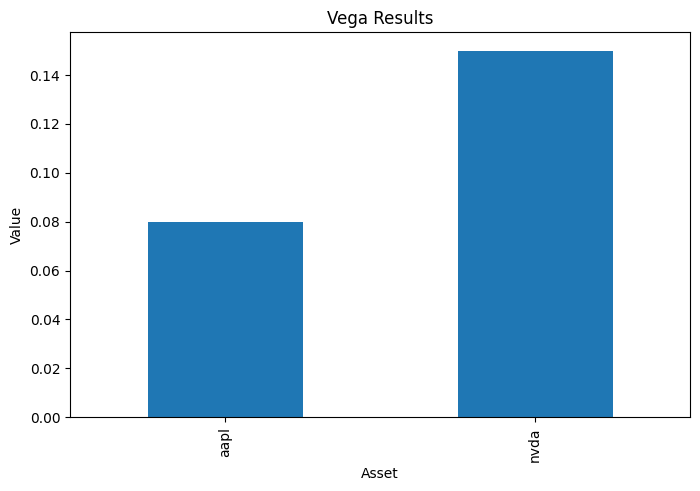

Exiting QuantLang. Goodbye!


In [9]:
def main():
    """Main function to handle user interaction and output results."""
    print("Welcome to QuantLang!")
    print("Type 'exit' or 'quit' to leave the program.")
    while True:
        try:
            expression = input("Enter expression (e.g., vega((0.4*aapl + 0.6*nvda) / usdsgd)): ").strip()
            if expression.lower() in ['exit', 'quit', 'q']:
                print("Exiting QuantLang. Goodbye!")
                break

            print(f"DEBUG: Received expression: {expression}")
            tokens = tokenize(expression)
            print(f"DEBUG: Tokens generated: {tokens}")

            ast = parse(tokens)
            print("DEBUG: AST generated:")
            print_ast(ast)

            result = evaluate(ast)
            html_output = f"<p>Result: {result}</p>"

            if isinstance(ast, FunctionNode):
                greek = ast.function
                greek_results = calculate_greek_for_portfolio(ast, greek)
                html_output += plot_greek_results(greek_results, greek)
            else:
                html_output += "<p>No Greek function detected.</p>"

            display(HTML(html_output))
        except Exception as e:
            html_error = f"<p>Error: {e}</p>"
            display(HTML(html_error))

if __name__ == "__main__":
    main()